In [1]:
from math import log
import operator

In [2]:
#计算香浓熵
def calShannon(dataset):
    size = len(dataset)
    label={}
    for feature in dataset:
        current_label=feature[-1]
        if current_label not in label.keys():
            label[current_label]=0
            
        label[current_label] +=1
        
    shannon=0.0
    for key in label:
        probability=float(label[key])/size
        shannon -= probability * log(probability,2)
    return shannon

In [3]:
#创建数据集和标签集
def createDataset():
    dataset=[
        [1,1,'yes'],
        [1,1,'yes'],
        [1,0,'no'],
        [0,1,'no'],
        [0,1,'no']
    ]
    labels=['no surfacing','flippers']
    return dataset,labels

In [4]:
#按照给定特征axis，划分数据集
def splitDataset(dataset,axis,value):
    res = []
    for feature in dataset:
        if feature[axis] == value:
            reduce_feature = feature[:axis]
            reduce_feature.extend(feature[axis+1:])
            res.append(reduce_feature)
    return res

In [5]:
#选择最好的数据集划分方式
def chooseBestSplit(dataset):
    num_features = len(dataset[0])-1
    base = calShannon(dataset)
    best_info_gain = 0.0
    best_feature = -1
    for i in range(num_features):
        feature_list = [example[i] for example in dataset]
        unique_vals = set(feature_list)
        new = 0.0
        for value in unique_vals:
            sub_dataset = splitDataset(dataset,i,value)
            probability = len(sub_dataset)/float(len(dataset))
            new += probability * calShannon(sub_dataset)
        info_gain = base-new
        if info_gain > best_info_gain:
            best_info_gain = info_gain
            best_feature = i
            
    return best_feature

In [6]:
#多数表决器
def majority(classList):
    classes = {}
    for vote in classList:
        if vote not in classes.keys():
            classes[vote]=0
            
        classes[vote] += 1
    sort = sorted(classes.items(),key=operator.itemgetter(1),reverse=True)
    return sort[0][0]

In [20]:
#创建树
def createTree(dataset,labels):
    classList=[example[-1] for example in dataset]
    if classList.count(classList[0]) == len(classList):
        return classList[0]
    if len(dataset[0]) == 1:
        return majority(classList)
    best_feature = chooseBestSplit(dataset)
    label = labels[best_feature]
    tree = {label:{}}
    del(labels[best_feature])
    feature_values = [example[best_feature] for example in dataset]
    unique_vals = set(feature_values)
    for value in unique_vals:
        sub_labels=labels[:]
        tree[label][value]=createTree(splitDataset(dataset,best_feature,value),sub_labels)
    return tree

In [21]:
#使用决策树的分类函数
def classify(tree,labels,test):
    first = list(tree.keys())[0]
    second = tree[first]
    index = labels.index(first)
    class_label = {}
    for key in second.keys():
        if test[index] == key:
            if type(second[key]).__name__ == 'dict':
                class_label = classify(second[key],labels,test)
            else:
                class_label = second[key]
    return class_label

In [22]:
#使用pickle存储决策树
def storeTree(tree,filename):
    import pickle
    f = open(filename,'wb')
    pickle.dump(tree,f)
    f.close()

In [23]:
#读出决策树结构
def grabTree(filename):
    import pickle
    f = open(filename,'rb')
    return pickle.load(f)

In [24]:
import matplotlib.pyplot as plt
decisionNode = dict(boxstyle="sawtooth",fc="0.8")
leafNode = dict(boxstyle="round4",fc="0.8")
arrow_args = dict(arrowstyle="<-")

In [40]:
#绘制带箭头的注解
def plotNode(node,center,parent,type):
    createPlot.axl.annotate(node,xy=parent,xycoords="axes fraction",
                           xytext=center,textcoords="axes fraction",va="center",
                           ha="center",bbox=type,arrowprops=arrow_args)

In [41]:
#获取决策树的叶节点数目
def getLeaves(tree):
    num_leaves = 0
    first = list(tree.keys())[0]
    second = tree[first]
    for key in second.keys():
        if type(second[key]).__name__ == 'dict' :
            num_leaves += getLeaves(second[key])
        else:
            num_leaves += 1
    return num_leaves


In [42]:
#获得决策树的深度
def getDepth(tree):
    depth = 0
    first = list(tree.keys())[0]
    second = tree[first]
    for key in second.keys():
        if type(second[key]).__name__ == 'dict' :
            tmp = 1 + getDepth(second[key])
        else:
            tmp = 1
        if tmp > depth:
            depth = tmp
    return depth

In [43]:
#定义树结构，测试树结构函数
def retriveTree(i):
    treeList = [
                {'no surfacing': 
                {0: 'no', 1: {'flippers':
                {0: 'no', 1: 'yes'}}}},
                {'no surfacing': {0: 'no', 1: {'flippers':
                {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}
                ]
    return treeList[i]

In [44]:
#计算父节点和自节点的中间位置，并添加文本标签信息
def addText(center,parent,text):
    x_mid=(parent[0]-center[0])/2.0 + center[0]
    y_mid=(parent[1]-center[1])/2.0 + center[1]
    createPlot.axl.text(x_mid,y_mid,text)

In [48]:
def plotTree(tree,parent,text):
    num_leaves = getLeaves(tree)
    depth = getDepth(tree)
    first = list(tree.keys())[0]
    center = (plotTree.xoff + (1.0+float(num_leaves))/2.0/plotTree.totalW,plotTree.yoff)
    addText(center,parent,text)
    plotNode(first,center,parent,decisionNode)
    second = tree[first]
    plotTree.yoff = plotTree.yoff - 1.0/plotTree.totalD
    for key in second.keys():
        if type(second[key]).__name__ == 'dict':
            plotTree(second[key],center,str(key))
        else:
            plotTree.xoff = plotTree.xoff + 1.0/plotTree.totalW
            plotNode(second[key],(plotTree.xoff,plotTree.yoff),
                    center,leafNode)
            addText((plotTree.xoff,plotTree.yoff),center,str(key))
    plotTree.yoff = plotTree.yoff + 1.0/plotTree.totalD

In [49]:
def createPlot(tree):
    fig = plt.figure(1,facecolor="white")
    fig.clf()
    axprops = dict(xticks=[],yticks=[])
    createPlot.axl = plt.subplot(111,frameon=False,**axprops)
    plotTree.totalW = float(getLeaves(tree))
    plotTree.totalD = float(getDepth(tree))
    plotTree.xoff = -0.5/plotTree.totalW
    plotTree.yoff = 1.0
    plotTree(tree, (0.5, 1.0), '')
    plt.show()

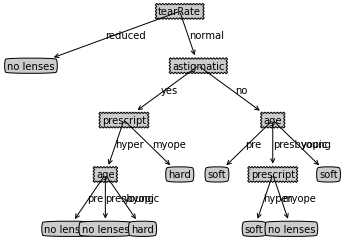

In [50]:
f = open('lenses.txt')
lenses = [inst.strip().split('\t') for inst in f.readlines()]
labels = ['age','prescript','astigmatic','tearRate']
tree = createTree(lenses,labels)
createPlot(tree)